In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from mne import read_epochs, set_log_level, compute_rank, concatenate_epochs
from mrmr import mrmr_classif
from random import randint
from sklearn import svm
from mne.decoding import Scaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import kurtosis, skew, moment, entropy, norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, GridSearchCV,ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg').filter(0,240)
epochs.drop_channels(epochs.info['bads'])
epochs.apply_baseline((-1.4,-0.4))
hbo = read_epochs('hbo_epo.fif')
hbr = read_epochs('hbr_epo.fif')

In [3]:
scaler = Scaler(info=epochs.info)
svm_rbf = svm.SVC(kernel="rbf", gamma="auto")
knn = KNeighborsClassifier(n_neighbors=3)
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
le = LabelEncoder()

In [4]:
def dwt_det_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return det

def dwt_aprox_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return aprx

def rms(x):
    return np.sqrt(np.mean(x**2))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def energy(x):
    return sum(x**2)

def med_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def calc_centroid(x, fs=7.81):
    energy = np.array(x) ** 2
    t = range(len(x))
    t = [float(x) / fs for x in t]
    t_energy = np.dot(np.array(t), np.array(energy))
    energy_sum = np.sum(energy)

    if energy_sum == 0 or t_energy == 0:
        centroid = 0
    else:
        centroid = t_energy / energy_sum

    return centroid

In [8]:
conditions = ['left','right','rest']
hbo_sub = hbo[conditions].copy()
hbr_sub = hbr[conditions].copy()

subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
eeg_data = subset.copy().crop(0.4,1.2).get_data()

hbo_sub.drop_channels(hbo_sub.info['bads'])
hbr_sub.drop_channels(hbr_sub.info['bads'])
y = le.fit_transform(hbr_sub.events[:,2])
chance = np.max([np.mean(y == y[0]), np.mean(y == y[1]), np.mean(y == y[2])])

t_min = 1
t_max = 10

hbo_sub = hbo_sub.copy().crop(t_min,t_max).get_data()
hbr_sub = hbr_sub.copy().crop(t_min,t_max).get_data()
hbo_avg = np.mean(hbo_sub, axis=0, keepdims=True)
hbr_avg = np.mean(hbr_sub, axis=0, keepdims=True)

hbo_sub = hbo_sub - hbo_avg
hbr_sub = hbr_sub - hbr_avg

nirs_data = np.concatenate([hbo_sub,  hbr_sub], axis=1)

y = le.fit_transform(subset.events[:,2])


In [9]:
print(genConf(hbo_sub.shape[0], 0.01))
print(genConf(hbo_sub.shape[0], 0.05))

NameError: name 'genConf' is not defined

In [24]:
subset.event_id

{'left': 130, 'right': 134, 'rest': 255}

In [25]:
le.inverse_transform([0,1,2])

array([130, 134, 255])

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


0.7086956521739131


(array([0, 2, 2, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 2,
        2], dtype=int64),
 [])

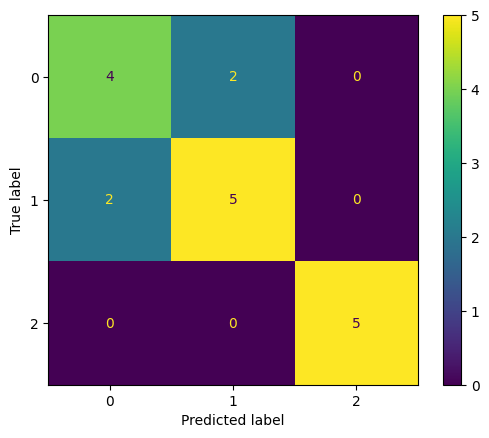

In [10]:
test_eeg('db9', 4, 6, features=8)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.86it/s]


0.708695652173913


(array([1, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0,
        1], dtype=int64),
 [])

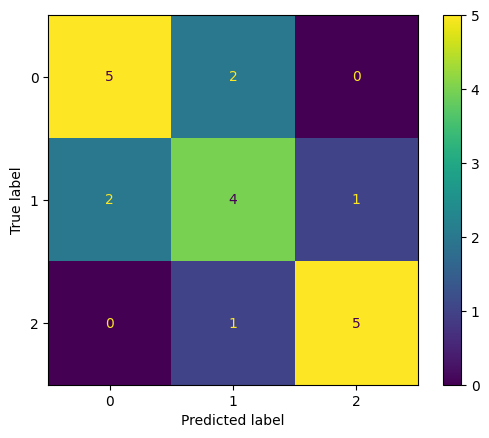

In [11]:
test_eeg('db9', 4, 6)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


0.6103260869565219


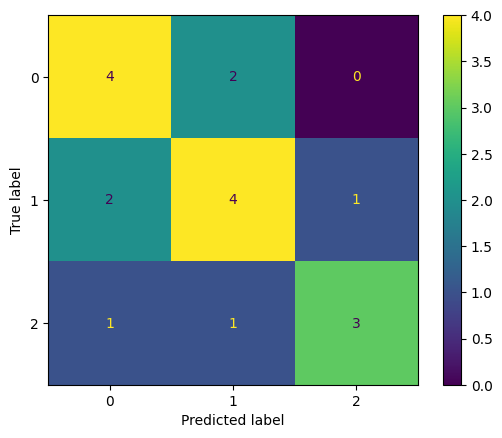

In [12]:
test_fnirs()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.75it/s]


lda  0.773913043478261


0.773913043478261

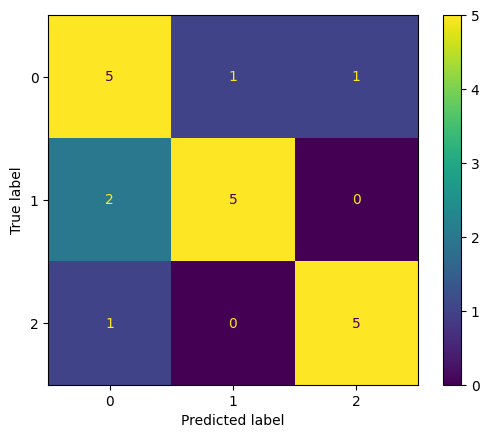

In [17]:
test_fnirs_eeg('db4', 4, 6, 21)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  2.06it/s]


lda  0.7695652173913043


0.7695652173913043

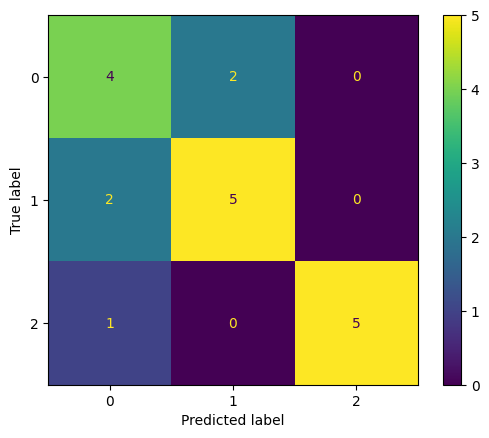

In [27]:
test_fnirs_eeg('db4', 4, 6, 23)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]


lda  0.6695652173913043
0.6695652173913043 ft 15


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


lda  0.6608695652173914


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:12<00:00,  1.38it/s]


lda  0.6956521739130435
0.6956521739130435 ft 17


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.01it/s]


lda  0.7173913043478262
0.7173913043478262 ft 18


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.35it/s]


lda  0.7391304347826086
0.7391304347826086 ft 19


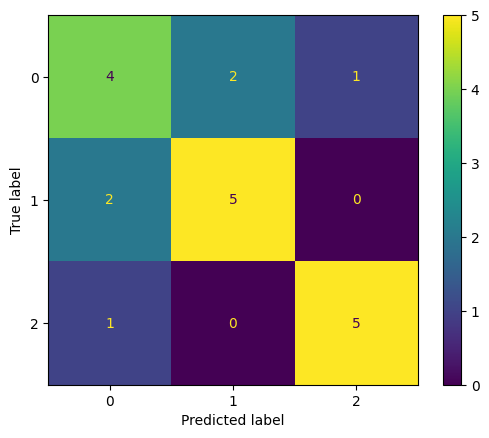

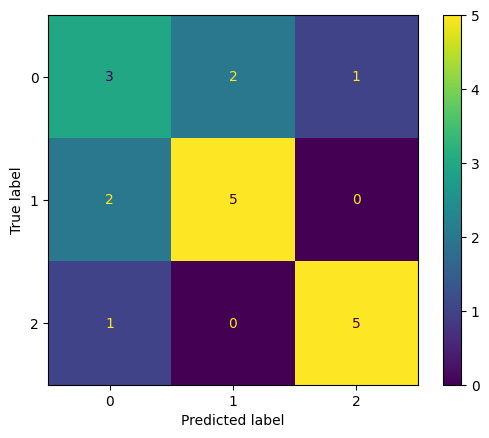

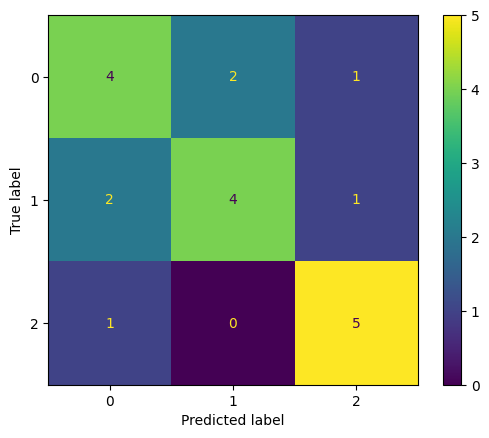

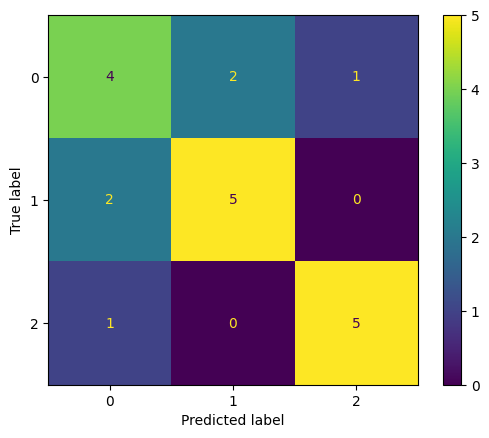

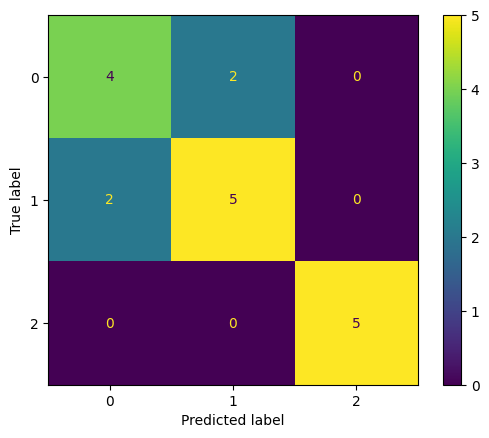

In [17]:
test_features('db9', 4, 6)

In [5]:
def test_features(db, lvl, lvl1):
    best_score = 0
    for feat in range(5):
        score = test_fnirs_eeg(db, lvl, lvl1, feat+15)
        if score > best_score:
            best_score = score
            print(best_score,'ft' , feat+15 )
    
def test_fnirs_eeg(db, lvl, lvl1, features=10):
    lda_score = []
    knn_score = []
    svm_score = []
    y_pred = []
    y_true = []
    
    cm = np.zeros([3,3])
    
    for train_rep in range(10):
        cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=randint(20,50))        
        cv_split = cv.split(eeg_data, y)
        
        mrmr_features = None
        
        lda_median_score = []
        knn_median_score = []
        svm_median_score = []
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            x_aprox_coeff = eeg_data[train_idx]
            test_aprox_coeff = eeg_data[test_idx]
            nirs_train = nirs_data[train_idx]
            nirs_test = nirs_data[test_idx]
            
            detail_coeffs = []
            aprox_coeffs = []
            test_detail_coeffs = []
            test_aprox_coeffs = []
            
            for dwt_lvl in range(lvl1+1):
                x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
                x_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 2, x_aprox_coeff, db=db)
                test_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, test_aprox_coeff, db=db)
                test_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 2, test_aprox_coeff, db=db)

                detail_coeffs.append(scaler.fit_transform(x_det_coeff.copy(),y_train))
                test_detail_coeffs.append(scaler.transform(test_det_coeff.copy()))
                aprox_coeffs.append(scaler.fit_transform(x_aprox_coeff.copy(),y_train))
                test_aprox_coeffs.append(scaler.transform(test_aprox_coeff.copy()))
                
            x_train = [] 
            
            x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl]**2))
            x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl]))

            x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1]**2))
            x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1]))
            
            x_train.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1]**2))
            x_train.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1]))

            x_train.append(np.apply_along_axis(np.std, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(np.mean, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(np.min, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(np.max, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(slope, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(skew, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(kurtosis, 2, nirs_data[train_idx]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, nirs_data[train_idx]))
            
            x_train = np.concatenate(x_train, axis=1)
            
            x_test = []
            
            x_test.append(np.apply_along_axis(np.std, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(np.max, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(np.min, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(rms, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(slope, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(skew, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(np.average, 2, test_detail_coeffs[lvl]**2))
            x_test.append(np.apply_along_axis(mean_abs_diff, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(temp_centroid, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(energy, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(kurtosis, 2, test_detail_coeffs[lvl]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, test_detail_coeffs[lvl]))

            x_test.append(np.apply_along_axis(np.std, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(np.max, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(np.min, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(rms, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(slope, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(skew, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(np.average, 2, test_detail_coeffs[lvl1]**2))
            x_test.append(np.apply_along_axis(mean_abs_diff, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(temp_centroid, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(energy, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(kurtosis, 2, test_detail_coeffs[lvl1]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, test_detail_coeffs[lvl1]))

            x_test.append(np.apply_along_axis(np.std, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(np.max, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(np.min, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(rms, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(slope, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(skew, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(np.average, 2, test_aprox_coeffs[-1]**2))
            x_test.append(np.apply_along_axis(mean_abs_diff, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(temp_centroid, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(energy, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(kurtosis, 2, test_aprox_coeffs[-1]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, test_aprox_coeffs[-1]))

            x_test.append(np.apply_along_axis(np.std, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(np.mean, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(np.min, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(np.max, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(slope, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(skew, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(kurtosis, 2, nirs_data[test_idx]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, nirs_data[test_idx]))

            x_test = np.concatenate(x_test, axis=1)
            
            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=features)
            all_f = np.linspace(0,x_train.shape[1],x_train.shape[1]).astype(int)
            selected = [True if i in mrmr_features else False for i in all_f]
           
            lda.fit(x_train[:,mrmr_features], y_train)
            lda_median_score.append(np.median(lda.score(x_test[:,mrmr_features], y_test)))
            cm += confusion_matrix(y_test, lda.predict(x_test[:,mrmr_features]))
        
        lda_score.append(np.median(lda_median_score))
        
    ConfusionMatrixDisplay((cm/30).astype(int)).plot()
    print('lda ',np.mean(lda_score))
    return np.mean(lda_score)

In [6]:
def test_fnirs(classifier='lda'):
    mrmr_score = []
    
    cm = np.zeros([3,3])
    estimator = None
    train_data = nirs_data
    for train_rep in range(10):
        cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=randint(20,50) + train_rep)        
        cv_split = cv.split(train_data, y)

        mrmr_features = None
        mrmr_median_score = []
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]
            
            x_train = []
            x_test = []
            
            x_train.append(np.apply_along_axis(np.std, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.mean, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.min, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(np.max, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(slope, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(skew, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(kurtosis, 2, train_data[train_idx]))
            x_train.append(np.apply_along_axis(calc_centroid, 2, train_data[train_idx]))

#             x_train.append(np.apply_along_axis(energy, 2, train_data[train_idx]))
#             x_train.append(np.apply_along_axis(entropy, 2, train_data[train_idx]))
            
            x_test.append(np.apply_along_axis(np.std, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.mean, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.min, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(np.max, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(slope, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(skew, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(kurtosis, 2, train_data[test_idx]))
            x_test.append(np.apply_along_axis(calc_centroid, 2, train_data[test_idx]))
            
            x_train = np.concatenate(x_train, axis=1)
            x_test = np.concatenate(x_test, axis=1)
            
            if classifier == 'svm':
                estimator = svm_rbf
            elif classifier == 'lda':
                estimator = lda
            elif classifier == 'rf':
                estimator = rf
            elif classifier == 'knn':
                estimator = knn
                
            #mrmr
            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
            all_f = np.linspace(0,x_train.shape[1],x_train.shape[1]).astype(int)
            selected = [True if i in mrmr_features else False for i in all_f]
           
            estimator.fit(x_train[:,mrmr_features], y_train)
            mrmr_median_score.append(np.median(estimator.score(x_test[:,mrmr_features], y_test)))
            cm += confusion_matrix(y_test, estimator.predict(x_test[:,mrmr_features]))
            
        mrmr_score.append(np.median(mrmr_median_score))
        
    ConfusionMatrixDisplay((cm/30).astype(int)).plot()
    print(np.mean(mrmr_score))

In [7]:
def test_eeg(db, lvl, lvl1, classifier='lda', selector='mrmr', features=10):
    score = []
    y_pred = []
    y_true = []
    detail_coeffs, aprox_coeffs = get_coeffs(db, lvl, lvl1) 
    
    cm = np.zeros([3,3])
    for train_rep in range(10):  
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=randint(20,50) +train_rep)        
        cv_split = cv.split(detail_coeffs[lvl], y)
        
        mrmr_features = None    
        median_score = []
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]  

            x_train, x_test = get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx)

            if classifier == 'svm':
                estimator = svm_rbf
            elif classifier == 'lda':
                estimator = lda
            elif classifier == 'rf':
                estimator = rf
            elif classifier == 'knn':
                estimator = knn
                
            if selector == 'rfe':
                if rfe_features is None:
                    rfe = RFE(rf, n_features_to_select=features)
                    rfe.fit(x_train, y_train)
                    rfe_features = rfe.support_
                x_train =  x_train[:,rfe_features]
                x_test = x_test[:,rfe_features]
            elif selector == 'mrmr':
                if mrmr_features is None:            
                    x_pd = pd.DataFrame(x_train)
                    mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=10)
                all_f = np.linspace(0,x_train.shape[1],x_train.shape[1]).astype(int)
                selected = [True if i in mrmr_features else False for i in all_f]
                
                x_train =  x_train[:,mrmr_features]
                x_test = x_test[:,mrmr_features]
            else:
                if relief_fit == False:
                    relief.fit(x_train, y_train)
                    relief_fit = True
                x_train = relief.transform(x_train.copy())
                x_test = relief.transform(x_test.copy())

            estimator.fit(x_train, y_train)
            median_score.append(np.median(estimator.score(x_test, y_test)))
            y_pred = estimator.predict(x_test)
            cm += confusion_matrix(y_test, y_pred)
            
        score.append(np.median(median_score))
        
    ConfusionMatrixDisplay((cm/30).astype(int)).plot()
    print(np.mean(score))
    return y_pred, y_true

def get_coeffs(db, lvl, lvl1):
    train_data = eeg_data
    x_aprox_coeff = train_data
          
    detail_coeffs = []
    aprox_coeffs = []
    for dwt_lvl in range(lvl1+1):
        x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
        x_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 2, x_aprox_coeff, db=db)

        detail_coeffs.append(scaler.fit_transform(x_det_coeff.copy(),y))
        aprox_coeffs.append(scaler.fit_transform(x_aprox_coeff.copy(),y))
    
    return detail_coeffs, aprox_coeffs

def get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx):
    x_train = []
    
    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][train_idx]))

    x_train = np.concatenate(x_train, axis=1)

    x_test = []

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][test_idx]))

    x_test = np.concatenate(x_test, axis=1)

    return x_train, x_test


In [7]:
# compute conf level
def p(n):
    return (n*chance+2)/(n+4)
def conf(n,p,alpha):
    return np.sqrt((p*(1-p))/(n+4))*norm.ppf(1-(alpha/2))
def genConf(n, alpha):
    res = np.zeros((n))
    for i in range(0,n):
        res[i] = p(i) + conf(i, p(i), alpha)
    return res[-1]*100